# Optical Velocimeter

### Define the Model

##### Initialisation of SymPy

In [23]:
import sympy as sym
from IPython.display import display, Math 

# Init Printing
sym.init_printing()

def func(name: str, f: sym.core, simplify: bool = False):
    display(sym.Eq(sym.symbols(name), sym.Eq(f, sym.simplify(f), evaluate=False) if simplify else f, evaluate=False))
    return f

##### Define the Parameters

In [24]:
f1, f2, vAuto, alpha = sym.symbols('f_1 f_2 v_{auto} \\alpha')
s, c = sym.symbols('s c', constant=True)


##### Define the Equations

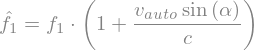

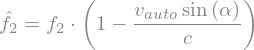

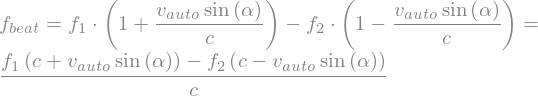

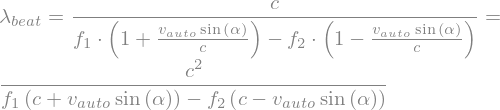

<IPython.core.display.Math object>

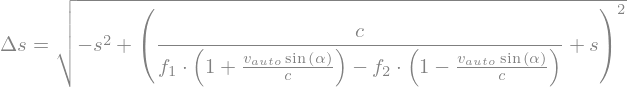

In [25]:
# Relative Velocity
vRel = func('v_{rel}', vAuto * sym.sin(alpha))

# Doppler Shift
f1Doppler = func('\hat{f_1}', f1 * (1 + vRel / c))
f2Doppler = func('\hat{f_2}', f2 * (1 - vRel / c))

# Beat Frequency and Wavelength
fBeat = func('f_{beat}', f1Doppler - f2Doppler, simplify=True)
lambdaBeat = func('\lambda_{beat}', c / fBeat, simplify=True)

# Delta S
display(Math('\Delta s = \\sqrt{\\left(s + \\lambda_{beat}\\right)^{2} - s^{2}}\\quad\\Rightarrow'))
deltaS = func('\Delta{}s', sym.sqrt((s + lambdaBeat)**2 - s**2))


##### Create Sliders for the Parameters

In [27]:
%matplotlib inline

from matplotlib import pyplot as plt
from scipy.optimize import fsolve
import numpy as np

from ipywidgets import interactive, fixed

def plot(_fBase, _fOffset, _alpha, _s):
    _fBase = 10**_fBase
    _fOffset = 10**_fOffset
    _alpha = np.deg2rad(_alpha)
    _c = 299792458
    
    _fBeat = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c), fBeat, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c)
    _lambdaBeat = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c), lambdaBeat, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c)
    _deltaS = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c, s), deltaS, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c, _s)
    
    _maximumSpeed = 100
    _minimumSpeed = fsolve(lambda _vAuto : _deltaS(_vAuto) * 1e3 - _s * np.tan(_alpha), 100)[0]
    if _minimumSpeed > _maximumSpeed:
        _minimumSpeed = 0.1
    _vAutoArray = np.linspace(_minimumSpeed, _maximumSpeed, 1000)
    
    fig = plt.figure(figsize=(13, 3))
    #ax = fig.add_subplot(1, 3, 1)
    #ax.plot(_vAutoArray, _fBeat(_vAutoArray) / 1e9)
    #ax.set_xlabel('v_{auto} [m/s]')
    #ax.set_ylabel('f_{beat} [GHz]')
    
    cut = 0
    #ax = fig.add_subplot(1, 3, 2)
    #ax.plot(_vAutoArray[cut:], _lambdaBeat(_vAutoArray[cut:]) * 1e3)
    #ax.set_xlabel('v_{auto} [m/s]')
    #ax.set_ylabel('\lambda_{beat} [mm]')
    
    
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(_vAutoArray[cut:], _deltaS(_vAutoArray[cut:]) * 1e3)
    ax.set_xlabel('v_{auto} [m/s]')
    ax.set_ylabel('\Delta{}s [mm]')
    
# plot(9e14, 2.89e11, 10, 100)
i = interactive(plot, _fBase=(9, 15, 1), _fOffset=(9, 15, 1), _alpha=(0, 90, 1), _s=(1, 300, 1))
i

interactive(children=(IntSlider(value=12, description='_fBase', max=15, min=9), IntSlider(value=12, descriptio…

##### Numeric Simulation

In [57]:

def plot(_fBase, _fOffset):
    _fBase = _fBase * 1e14
    _fOffset = _fOffset * 1e14
    _alpha = np.deg2rad(10)
    _s = 100
    _c = 299792458
    _f1 = _fBase
    _f2 = _fBase - _fOffset
    
    _1n = lambda _vAuto : _vAuto * np.sin(_alpha) / _c
    _deltaS = lambda _vAuto : np.sqrt(-_s**2 + (_c / (_f1 * (1 + _1n(_vAuto)) - (_f2 * (1 - _1n(_vAuto)))) + _s)**2)
    
    _maximumSpeed = 100
    _minimumSpeed = 0.1
    if _minimumSpeed > _maximumSpeed:
        _minimumSpeed = 0.1
    _vAutoArray = np.linspace(_minimumSpeed, _maximumSpeed, 1000)
    
    fig = plt.figure(figsize=(13, 3))
    cut = 1
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(_vAutoArray[cut:], _deltaS(_vAutoArray[cut:]) * 1e3)
    ax.axes.set_xlim([_minimumSpeed, _maximumSpeed])
    ax.set_xlabel('v_{auto} [m/s]')
    ax.set_ylabel('\Delta{}s [mm]')
    
# plot(9e14, 2.89e11, 10, 100)
i = interactive(plot, _fBase=(1, 1000, 1), _fOffset=(0, 10, 0.1))
i

interactive(children=(IntSlider(value=500, description='_fBase', max=1000, min=1), FloatSlider(value=5.0, desc…

In [86]:

def plot(_fBase):
    _fBase = _fBase * 1e14
    _alpha = np.deg2rad(10)
    _s = 100
    _c = 299792458
    _f1 = _fBase
    _f2 = lambda _fOffset: _fBase - _fOffset
    
    _1n = lambda _vAuto : _vAuto * np.sin(_alpha) / _c
    _deltaS = lambda _vAuto, _fOffset : np.sqrt(-_s**2 + (_c / (_f1 * (1 + _1n(_vAuto)) - (_f2(_fOffset) * (1 - _1n(_vAuto)))) + _s)**2)
    _relativeDifference = lambda _fOffset : _deltaS(0.1, _fOffset) - _deltaS(100, _fOffset)
    _differenceRatio = lambda _fOffset : _relativeDifference(_fOffset) / _deltaS(100, _fOffset)
    
    _fOffsetArray = np.linspace(0.01, 0.5, 1000) * 1e12
    
    fig = plt.figure(figsize=(13, 3))
    cut = 1
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(_fOffsetArray, _relativeDifference(_fOffsetArray) * 1e3)
    ax.set_xlabel('f_{Offset} [Hz]')
    ax.set_ylabel('\Delta s [mm]')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.plot(_fOffsetArray, _differenceRatio(_fOffsetArray) * 1e3)
    ax.set_xlabel('f_{Offset} [Hz]')
    ax.set_ylabel('\Delta s [mm]')
    
# plot(9e14, 2.89e11, 10, 100)
i = interactive(plot, _fBase=(1, 10, 1))
i

interactive(children=(IntSlider(value=5, description='_fBase', max=10, min=1), Output()), _dom_classes=('widge…

### Test with example Lasers

In [179]:
import pandas as pd

lambdaArray = [ 676.4e-9,
                671e-9,
                652e-9,
                647.1e-9,
                635e-9,
                632.8e-9,
                578.2e-9,
                577e-9,
                568.2e-9,
                532e-9,
                530.9e-9,
                528.7e-9,
                520e-9,
                514.5e-9,
                510.6e-9,
                496.5e-9,
                488e-9,
                476.4e-9,
                476.2e-9,
                473e-9,
                457.9e-9,
                440e-9,
                413.1e-9,
                405e-9]             

f = lambda _lambdaArray : 299792458 / _lambdaArray

alpha = np.deg2rad(45)
s = 100
print(s * np.tan(alpha))

_1n = lambda _vAuto : _vAuto * np.sin(alpha) / c
deltaS = lambda _vAuto, _l1, _l2 : np.sqrt(-s**2 + (c / (f(_l1) * (1 + _1n(_vAuto)) - (f(_l2) * (1 - _1n(_vAuto)))) + s)**2) * 1e3

maximumDS = lambda _l1, _l2 : deltaS(0.1, _l1, _l2)
minimumDS = lambda _l1, _l2 : deltaS(100, _l1, _l2)
difference = lambda _l1, _l2 : maximumDS(_l1, _l2) - minimumDS(_l1, _l2)
ratio = lambda _l1, _l2 : difference(_l1, _l2) / maximumDS(_l1, _l2)

fPairs = [ (_l1 * 1e9, _l2 * 1e9, maximumDS(_l1, _l2), difference(_l1, _l2) * 1e3) for _l1 in lambdaArray for _l2 in lambdaArray if maximumDS(_l1, _l2) < 100 and difference(_l1, _l2) > 0.0002]

pd.DataFrame(fPairs, columns=['l1 [nm]', 'l2 [nm]', 'maxDS [mm]', 'difference [um]'])


99.99999999999999


/tmp/ipykernel_79643/917918217.py:35: RuntimeWarning: invalid value encountered in sqrt
  deltaS = lambda _vAuto, _l1, _l2 : np.sqrt(-s**2 + (c / (f(_l1) * (1 + _1n(_vAuto)) - (f(_l2) * (1 - _1n(_vAuto)))) + s)**2) * 1e3


,l1 [nm],l2 [nm],maxDS [mm],difference [um]
0,652.0,676.4,60.123700,0.385620
1,652.0,671.0,67.861472,0.556717
2,647.1,676.4,54.659883,0.290870
3,647.1,671.0,60.278582,0.391661
4,635.0,671.0,48.653253,0.207946
5,635.0,652.0,69.791289,0.622485
6,635.0,647.1,82.412845,1.028789
7,632.8,652.0,65.557357,0.516851
8,632.8,647.1,75.677354,0.797979
9,568.2,578.2,81.059643,1.094794
